<a href="https://colab.research.google.com/github/fuat-arslan/Pytorch_Scratch/blob/main/CV/GoogLeNet_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Written by Fuat Arslan

Original paper is [Going deeper with convolutions
](https://arxiv.org/pdf/1409.4842v1.pdf)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

Basic conv block that is Conv + ReLU + BatchNorm. Even though Batchnorm is not mentioned which is not invented at that time, I used  it as general convention.

In [2]:
class conv_base(nn.Sequential):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

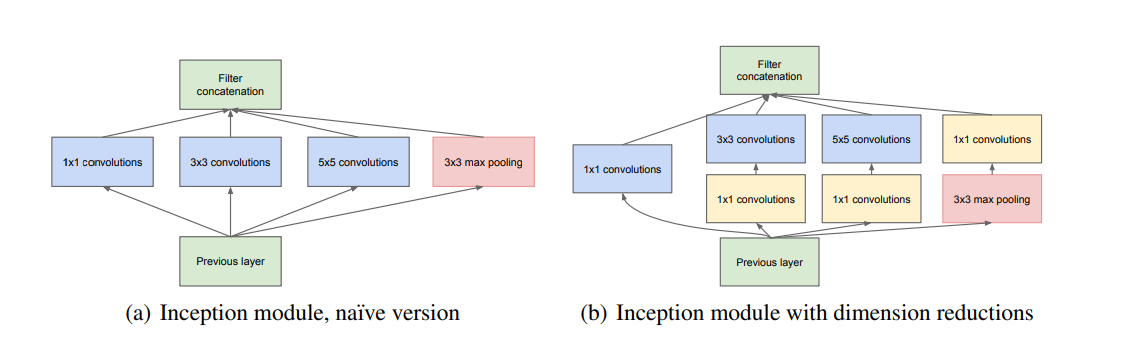

In [13]:
class Inception(nn.Module):
    def __init__(self, in_channels, out_1x1, out_3x3_red, out_3x3, out_5x5_red, out_5x5, pool_proj):
        super().__init__()

        self.b1 = conv_base(in_channels, out_1x1, kernel_size=1)

        self.b2 = nn.Sequential(
            conv_base(in_channels, out_3x3_red, kernel_size=1),
            conv_base(out_3x3_red, out_3x3 ,kernel_size=3, padding=1)
        )

        self.b3 = nn.Sequential(
            conv_base(in_channels, out_5x5_red, kernel_size=1),
            conv_base(out_5x5_red, out_5x5, kernel_size=5, padding=2)
        )

        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_base(in_channels, pool_proj, kernel_size=1),
        )

    def forward(self, x):
        return torch.cat(
            [self.b1(x), self.b2(x), self.b3(x), self.b4(x)], 1
        )


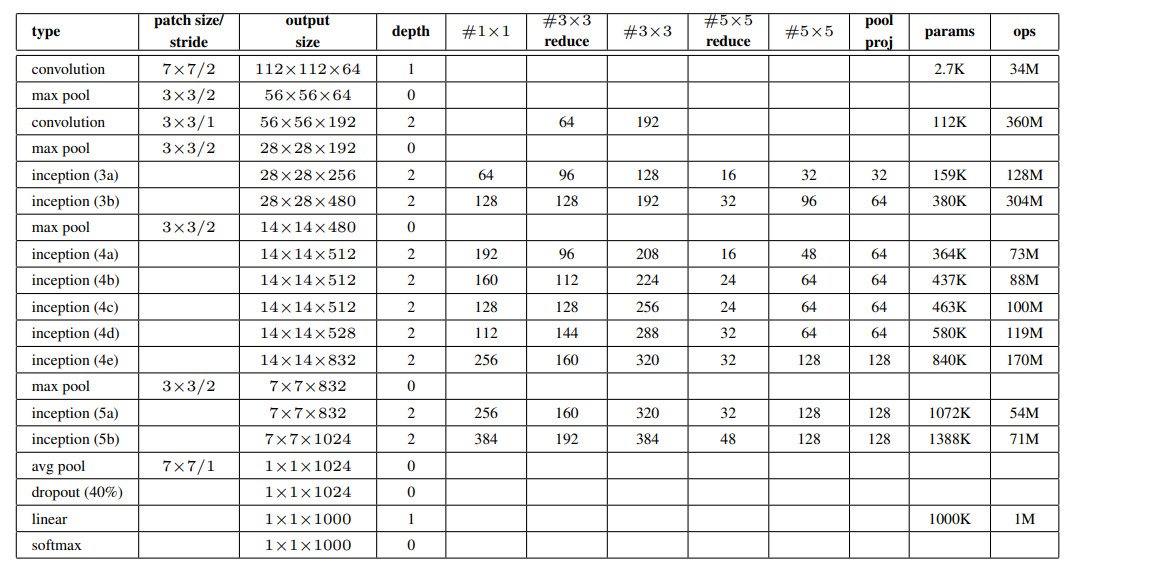

Auxulary classifier

In [10]:
class AuxCLS(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = conv_base(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [22]:
class GoogLeNet(nn.Module):
    def __init__(self, n_classes=1000):
        super().__init__()

        self.net = nn.ModuleDict(
            OrderedDict(
                [
                    ('conv1', conv_base(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)),
                    ('maxpool1', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                    ('conv2', conv_base(64, 192, kernel_size=3, stride=1, padding=1)),
                    ('maxpool2', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                    ('inception3a', Inception(192, 64, 96, 128, 16, 32, 32)),
                    ('inception3b', Inception(256, 128, 128, 192, 32, 96, 64)),
                    ('maxpool3', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                    ('inception4a', Inception(480, 192, 96, 208, 16, 48, 64)),
                    ('inception4b', Inception(512, 160, 112, 224, 24, 64, 64)),
                    ('inception4c', Inception(512, 128, 128, 256, 24, 64, 64)),
                    ('inception4d', Inception(512, 112, 144, 288, 32, 64, 64)),
                    ('inception4e', Inception(528, 256, 160, 320, 32, 128, 128)),
                    ('maxpool4', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                    ('inception5a', Inception(832, 256, 160, 320, 32, 128, 128)),
                    ('inception5b', Inception(832, 384, 192, 384, 48, 128, 128)),
                    ('avgpool', nn.AvgPool2d(kernel_size=7, stride=1)),
                    ('flatten', nn.Flatten()),
                    ('dropout', nn.Dropout(p=0.4)),
                    ('fc1', nn.Linear(1024, n_classes)),

                ]
            )

        )

        self.aux1 = AuxCLS(512, n_classes)
        self.aux2 = AuxCLS(528, n_classes)


    def forward(self, x):

        for name, layer in self.net.items():
            # print(name,x.shape)
            x = layer(x)
            # print(name,x.shape)

            if name == 'inception4a' and self.training:
                aux_result1 = self.aux1(x)
            elif name == 'inception4d' and self.training:
                aux_result2 = self.aux2(x)


        return aux_result1, aux_result2, x

In [26]:
BATCH_SIZE = 64
x = torch.randn(BATCH_SIZE, 3, 224, 224)
model = GoogLeNet(1000)
print(model(x)[2].shape)
assert model(x)[2].shape == torch.Size([BATCH_SIZE, 1000])

torch.Size([64, 1000])


In [27]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

13389064